## Reference Plots - Model - delta_v = 1e6cm/s; delta_x = 1pc

In [5]:
#import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import (center_and_r_vir, remove_bulk_velocity,
                                read_unit_from_info)
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure

%matplotlib inline

In [6]:
run = "hydro_59"
out = "output_00050"
path = "bulk1/data_2/" + run + "/output/"
data = pynbody.load(path + out)
aexp = data.properties['a']
data.physical_units()

r_vir = center_and_r_vir(data, aexp, path)
remove_bulk_velocity(data)
r_e = 0.1 * r_vir

sph_5 = pynbody.filt.Sphere(radius='%f kpc' % r_e)
region = data[sph_5]

omega_b, unit_l, unit_d, unit_t = read_unit_from_info(data)

('shifting on Stars:', SimArray([ 0.00308878, -0.03302971, -0.04676732], 'kpc'))
('virial radius:', SimArray(152.40432611, 'kpc'))


In [7]:
m_p = pynbody.array.SimArray(1.672621e-24, "g")
G = pynbody.array.SimArray(6.6732e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")
K_b = pynbody.array.SimArray(1.380622e-16, "g cm**2 s**-2 K**-1")
K_b_ev = pynbody.array.SimArray(8.617e-5, "eV K**-1")
K_b_erg = pynbody.array.SimArray(1.380622e-16, "erg K**-1")
c_cgs = pynbody.array.SimArray(2.9979245e10, "cm s**-1")
h_ev = pynbody.array.SimArray(4.135667e-15, "eV s")
mH_cgs = pynbody.array.SimArray(1.6735575e-24, 'g')  # hydrogen mass
eV_to_ergs = pynbody.array.SimArray(1.60218e-12, "erg eV**-1")
L_sun = pynbody.array.SimArray(3.839e33, "erg s**-1")
M_sun = pynbody.array.SimArray(2e33, "g")

In [8]:
def get_filename(species):
    # filename is already given
    if (species[-4:] == '.dat') or (species[-4:] == '.txt'):
        return species
    # molecule is chosen
    THIS_FOLDER = os.path.dirname(os.path.abspath(__file__))
    database = os.path.join(THIS_FOLDER, 'LAMDA')
    if species == 'HCO+':
        filename = os.path.join(database, 'HCO+.dat')
    elif species == 'H13CO+':
        filename = os.path.join(database, 'H13CO+.dat')
    elif species == 'N2H+':
        filename = os.path.join(database, 'N2H+.dat')
    elif species == 'SiO':
        filename = os.path.join(database, 'SiO.dat')
    elif species == 'HNC':
        filename = os.path.join(database, 'HNC.dat')
    elif species == 'HCN':
        filename = os.path.join(database, 'HCN.dat')
    elif species == 'CO':
        filename = os.path.join(database, 'CO.dat')
    else:
        print('Unknow species. Chose from HCO+, H13CO+, N2H+, SiO, HNC, HCN, CO')
        print('or provide a LAMDA datafile.')
        exit()

    return filename


def read_file(species, c_cgs, h_ev, K_b_ev):
    filename = get_filename(species)
    f = open(filename, 'r')

    f.readline()
    species = f.readline()

    f.readline()
    mu = float(f.readline())  # molecular weight

    f.readline()
    num_lvls = int(f.readline())  # number of energy levels

    # read energy levels: energy E, statistical weight g
    f.readline()
    E = []
    g = []
    for l in range(num_lvls):
        words = f.readline().split()
        E.append(float(words[1]) *c_cgs*h_ev) # cm^-1 -> eV
        g.append(float(words[2]))

    f.readline()
    num_trans = int(f.readline())  # number of radiative transistions

    # read transistions: upper lvl, lower lvl, A-coefficient, frequency
    f.readline()
    A = np.zeros((num_lvls, num_lvls))
    freq = np.zeros((num_lvls, num_lvls))
    for t in range(num_trans):
        words = f.readline().split()
        up = int(words[1]) - 1
        low = int(words[2]) - 1
        if up-low==1:
            A[up][low] = float(words[3])  # s^-1
            freq[up][low] = float(words[4]) * 1e9  # GHz -> Hz
            #freq[low][up] = freq[up][low] #un-comment this only 
            #if low to up transitions are also allowed

    # compute B-coefficient via Einstein relations
    # Bij = coeff for stimulated emission, Bji = coeff for extinction (j<i)
    B = np.zeros((num_lvls, num_lvls))
    for i in range(0, num_lvls):
        for j in range(0, i):
            if A[i][j] != 0:
                B[i][j] = ((A[i][j] * (c_cgs**2)) /
                (2*h_ev * (freq[i][j])**3)) # cm2/(eV*s)
                B[j][i] = B[i][j] * g[i]/g[j]

    f.close()
    E = np.array(E) #eV
    g = np.array(g) 
    freq = np.array(freq) #Hz
    A = np.array(A) #s-1
    B = np.array(B) #cm2/(eV*s)
    return mu, num_lvls, E, g, freq, A, B


def partion_function(T, num_lvls, g, E, K_b_ev):
    Z=0.0
    for i in range(0,num_lvls):
        Z = Z + g[i]*np.exp(-E[i]/(K_b_ev*T))
    return np.asarray(Z)


def calc_lvlpops_partion(T, num_lvls, g, E, K_b_ev):
    ni = np.zeros(num_lvls)
    Z = partion_function(T, num_lvls, g, E, K_b_ev)
    for i in range(0, num_lvls):
        ni[i] = g[i]*np.exp(-E[i]/(K_b_ev*T)) / Z
    return np.asarray(ni), Z

In [9]:
mu, num_lvls, E, g, freq, A, B = read_file('CO.txt',c_cgs, h_ev, K_b_ev)
ni, Z = calc_lvlpops_partion(T_mean, num_lvls, g, E, K_b_ev)
c_s_CO = np.sqrt(K_b * T_mean/(mH_cgs*mu))
u = 1 #upper level
l = 0 #lower level
nu = freq[u][l]
x_1 = ni[u]
x_0 = ni[l]
A_10 = A[u][l]
B_10 = B[u][l]
B_01 = B[l][u]    

print (x_1)
print (x_0)
print Z

0.43479505590767203
0.2520174421256517
3.9679793254207247


In [29]:
ni_3, Z_3 = calc_lvlpops_partion(2.7, num_lvls, g, E, K_b_ev)

In [32]:
x_1_3 = ni_3[1]
x_1_3

0.2766612322931716

In [33]:
x_1/x_1_3

1.5715792643001376

In [10]:
# x_1 = 0.4347950859536656
# x_0 = 0.25201748686058306
# A_10 = pynbody.array.SimArray(7.203e-08, "s**-1")
# B_10 = pynbody.array.SimArray(5.10995088e-06, "cm**2 eV**-1 s**-1")
# B_01 = pynbody.array.SimArray(1.53298527e-05, "cm**2 eV**-1 s**-1")
# nu = pynbody.array.SimArray(1.15271202e+11, "Hz")
# mu = 28.0
c_s_CO = np.sqrt(K_b * T_mean/(mH_cgs*mu))

In [11]:
def make_pdf(s, s_bar, sigma_s):
    return ((1./np.sqrt(2*np.pi*(sigma_s**2))) *
            (np.exp(-0.5*(((s - s_bar)/sigma_s)**2))))


def calc_lambda_jeans(n_H, T_mean, m_p, K_b):
    return np.asarray(np.sqrt(K_b * T_mean/m_p) /
                      np.sqrt(4.*np.pi * G * n_H * m_p))


def calc_n_LW(n_H, G_o, lambda_jeans, metal, m_p):
    kappa = 1000 * m_p * metal
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    return np.asarray(G_o * exp_tau)


def calc_X_H2(n_H, metal, n_LW):
    DC = 1.7e-11
    CC = 2.5e-17            # cm3 s-1
    numerator = DC * n_LW
    denominator = CC * metal * n_H
    X_H2 = 1. / (2. + (numerator/denominator))
    return np.asarray(2*X_H2)


def calc_n_LW_ss(n_H, n_H2, metal, G_o, lambda_jeans, m_p):
    kappa = 1000 * m_p * metal
    rad_field_outside = G_o  # in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    N_H2 = n_H2 * lambda_jeans
    term1 = 0.965/((1+(N_H2/5e14))**2)
    term2 = ((0.035/np.sqrt(1+(N_H2/5e14))) *
             np.exp(-1*np.sqrt(1+(N_H2/5e14))/1180))
    S_H2 = term1 + term2
    n_LW_ss = rad_field_outside * exp_tau * S_H2
    return np.asarray(n_LW_ss)


def self_shielding_iterations(n_H, G_o, lambda_jeans, metal, m_p):
    ctr = 16
    n_LW = calc_n_LW(n_H, G_o, lambda_jeans, metal, m_p)
    X_H2 = calc_X_H2(n_H, metal, n_LW)
    n_H2 = n_H * X_H2
    n_H2_ss = n_H2
    for _ in range(ctr):
        n_LW_ss = calc_n_LW_ss(n_H, n_H2_ss, metal, G_o, lambda_jeans, m_p)
        X_H2_ss = calc_X_H2(n_H, metal, n_LW_ss)
        """
        if (np.sum(np.square(n_H2_ss - n_H * X_H2_ss)) < 1e-5):
            n_H2_ss = n_H * X_H2_ss
            break
        """
        n_H2_ss = n_H * X_H2_ss
    return n_LW, n_H2, n_LW_ss, X_H2_ss, n_H2_ss


def calc_integral(s, pdf, X, ds):
    return np.sum(np.exp(s) * pdf * X * ds)


def calc_X_CO(n_H, n_H2, n_LW):
    rate_CHX = 5.0e-10 * n_LW
    rate_CO = 1.0e-10 * n_LW
    x0 = 2.0e-4
    k0 = 5.0e-16  # cm3 s-1
    k1 = 5.0e-10  # cm3 s-1
    factor_beta = rate_CHX/(n_H*k1*x0)
    beta = 1./(1.+factor_beta)
    factor_CO = rate_CO/(n_H2*k0*beta)
    X_CO = 1./(1.+factor_CO)
    return np.asarray(X_CO)


def calc_n_CO(n_H, X_CO, metal):
    abundance_Ctot = 1e-4 # n_C/n_H as defined by nucleosynthesis
    return n_H * abundance_Ctot * metal * X_CO # CO/cc


def tau_LVG(n_CO, nu, lambda_jeans, x_1, x_0, B_10, B_01, c_s_CO, c_cgs, h_ev):
    # units: eV*s * Hz * cm * 1/cm3 * cm2/(eV*s) * 1/(Hz) = none
    delta_v = 1e5*(lambda_jeans/(1*3.08e18))**0.5
    delta_nu_1 = c_s_CO*nu/c_cgs #"Hz"
    delta_nu_2 = delta_v*nu/c_cgs
    delta_nu_3 = (1e6*(lambda_jeans/(1*3.08e18))**0.5)*nu/c_cgs
    tau_1 = h_ev*nu*lambda_jeans*n_CO*((x_0*B_01)-(x_1*B_10))/(4*np.pi*delta_nu_1)
    tau_2 = h_ev*nu*lambda_jeans*n_CO*((x_0*B_01)-(x_1*B_10))/(4*np.pi*delta_nu_2)
    tau_3 = h_ev*nu*lambda_jeans*n_CO*((x_0*B_01)-(x_1*B_10))/(4*np.pi*delta_nu_3)
    return np.asarray(tau_1), np.asarray(tau_2), np.asarray(tau_3)  
    
def beta_LVG(tau):
    beta_lvg = np.zeros(len(tau))
    for i in range(0, len(tau)):
        if tau[i] < 0.01:
            beta_lvg[i] = 1. - tau[i]/2.
        elif tau[i] > 100.:
            beta_lvg[i] = 1./tau[i]
        else:
            beta_lvg[i] = (1.0 - np.exp(-tau[i])) / tau[i]
    return beta_lvg


def calc_integrated_emissivity(n_CO, nu, x_1, A_10, h_ev):
    #units: eV*s * Hz * cm-3 * s-1 = eV/cm3/s
    j_10 = h_ev * nu * n_CO * x_1 * A_10
    return j_10

def inside_loop(n_H_mean):
    j_10_3 = np.zeros(100)
    n_H = n_H_mean * np.exp(s)
    lambda_jeans = calc_lambda_jeans(n_H, T_mean, m_p, K_b)

    n_LW, n_H2, n_LW_ss, X_H2_ss, n_H2_ss = self_shielding_iterations(
        n_H, G_o, lambda_jeans, metal, m_p)

    X_H2_bar = calc_integral(s, pdf, X_H2_ss, ds)
    X_CO = calc_X_CO(n_H, n_H2, n_LW)
    n_CO = calc_n_CO(n_H, X_CO, metal)
    X_CO_bar = calc_integral(s, pdf, X_CO, ds)

    tau_nu_1, tau_nu_2, tau_nu_3 = tau_LVG(n_CO, nu, lambda_jeans, x_1, x_0, 
                     B_10, B_01, c_s_CO, c_cgs, h_ev)
    beta_nu_1 = beta_LVG(tau_nu_1)
    beta_nu_2 = beta_LVG(tau_nu_2)
    beta_nu_3 = beta_LVG(tau_nu_3)
#     T_exc = 3.+0.0*beta_nu_3 #(10.*(1.0-beta_nu_3))+(3.*beta_nu_3)
#     for i in range(0, len(T_exc)):
#         ni_3, Z_3 = calc_lvlpops_partion(T_exc[i], num_lvls, g, E, K_b_ev)
#         x_1_3 = ni_3[1]
# #         print x_1_3, T_exc[i], Z_3,E[]
#         j_10_3[i] = calc_integrated_emissivity(n_CO[i], nu, x_1_3, A_10, h_ev)  # eV/cm3/s
    
    j_10 = calc_integrated_emissivity(n_CO, nu, x_1, A_10, h_ev)  # eV/cm3/s
    

    # m_H2 = m_p * (dx**3) * X_H2_ss  #g cm3
    l_CO_1 = j_10 * beta_nu_1 * eV_to_ergs  #ergs/cm3/s
    l_CO_2 = j_10 * beta_nu_2 * eV_to_ergs  #ergs/cm3/s
    l_CO_3 = j_10 * beta_nu_3 * eV_to_ergs  #ergs/cm3/s

    alpha_CO = M_sun*((c_cgs/nu)**3)*1e-5*((3.24078e-19)**2)/(2*K_b_erg)
    #conversion factor: erg/cm3/s to K km s-1 pc2 M_sol-1 cm-3
    l_CO_SI_1 = l_CO_1 * alpha_CO # K km s-1 pc2 M_sol-1 cm-3
    l_CO_SI_2 = l_CO_2 * alpha_CO # K km s-1 pc2 M_sol-1 cm-3
    l_CO_SI_3 = l_CO_3 * alpha_CO # K km s-1 pc2 M_sol-1 cm-3
    
    l_CO_bar_1 = np.sum(l_CO_1*pdf*ds)
    l_CO_bar_2 = np.sum(l_CO_2*pdf*ds)
    l_CO_bar_3 = np.sum(l_CO_3*pdf*ds)
    
    l_CO_SI_bar_1 = np.sum(l_CO_SI_1*pdf*ds)
    l_CO_SI_bar_2 = np.sum(l_CO_SI_2*pdf*ds)
    l_CO_SI_bar_3 = np.sum(l_CO_SI_3*pdf*ds)
    
    return X_H2_bar, X_CO_bar, l_CO_bar_1, l_CO_SI_bar_1, l_CO_bar_2, l_CO_SI_bar_2, l_CO_bar_3, l_CO_SI_bar_3

In [12]:
mach_no = 10
metal = 1
G_o = 2.0
dx = pynbody.array.SimArray(5.74179996e+20, "cm")

sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
s_bar = -0.5*(sigma_s**2)
smin = -7*sigma_s + s_bar
smax = 7*sigma_s + s_bar

s = np.linspace(smin, smax, num=100, endpoint=False)
ds = np.diff(s)[0]
pdf = make_pdf(s, s_bar, sigma_s)

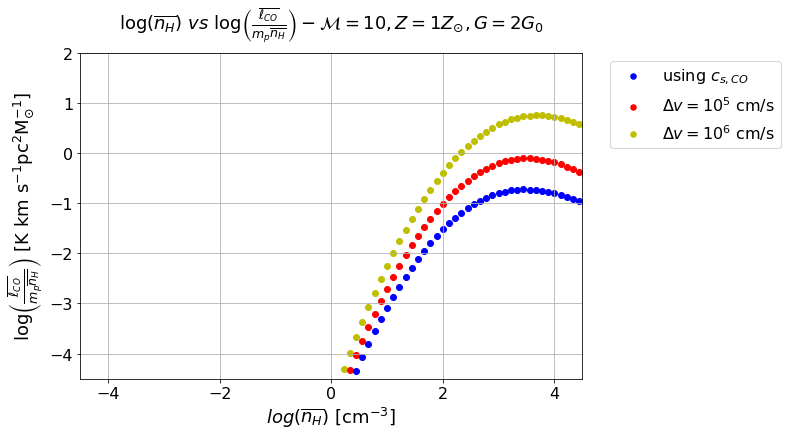

In [28]:
plt.rc('figure', titlesize=18)
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize

fig, ax = plt.subplots(figsize=(9,6))
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-4, 7, 100), "cm**-3")
for i in range(0, len(n_H_mean_arr)):
    n_H_mean = n_H_mean_arr[i]
    X_H2_bar, X_CO_bar, l_CO_bar_1, l_CO_SI_bar_1, l_CO_bar_2, l_CO_SI_bar_2, l_CO_bar_3, l_CO_SI_bar_3  = inside_loop(n_H_mean)
    n_H2_mean = X_H2_bar * n_H_mean

    alpha_1 = l_CO_bar_1/(n_H_mean*m_p) #[erg s-1 M_sol-1]
    alpha_2 = l_CO_bar_2/(n_H_mean*m_p) #[erg s-1 M_sol-1]
    alpha_3 = l_CO_bar_3/(n_H_mean*m_p) #[erg s-1 M_sol-1]

    alpha_1_SI = l_CO_SI_bar_1/(n_H_mean*m_p) #[K km s**-1 pc**2 Msol**-1]
    alpha_2_SI = l_CO_SI_bar_2/(n_H_mean*m_p) #[K km s**-1 pc**2 Msol**-1]
    alpha_3_SI = l_CO_SI_bar_3/(n_H_mean*m_p) #[K km s**-1 pc**2 Msol**-1]
    plt.scatter(np.log10(n_H_mean), np.log10(alpha_1_SI), 
                c="b")
    plt.scatter(np.log10(n_H_mean), np.log10(alpha_2_SI), 
                c="r")
    plt.scatter(np.log10(n_H_mean), np.log10(alpha_3_SI), 
                c="y")
#     plt.scatter(np.log10(n_H_mean), n_H2_mean/n_H_mean, 
#                 c="k")
ax.set_xlabel(r'$log(\overline{n_H}) \ [\rm{cm^{-3}}]$')
ax.set_ylabel(r'$\log\left(\frac{\overline{\ell_{CO}}}{m_p \overline{n_H}}\right) \ [\rm{K\ km\ s^{-1} pc^{2} M_{\odot}^{-1}}] $')
plt.scatter(np.log10(1e12), 1, 
                c="b", label=r"using $c_{s, CO}$")
plt.scatter(np.log10(1e12), 1, 
            c="r", label=r"$\Delta v=10^5\ \rm{cm/s}$")
plt.scatter(np.log10(1e12), 1, 
            c="y", label=r"$\Delta v=10^6\ \rm{cm/s}$")
# plt.scatter(np.log10(1000000), 1, 
#             c="k", label="$n_{H2, mean}/n_{H, mean}$")
legend = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
legend.legendHandles[0]._sizes = [30]
legend.legendHandles[1]._sizes = [30]
legend.legendHandles[2]._sizes = [30]
ax.set_ylim([-4.5,2])
ax.set_xlim([-4.5, 4.5])
plt.grid(b=True, which='both', axis='both')
plt.title(r"$\log(\overline{n_H})\ vs\ \log\left(\frac{\overline{\ell_{CO}}}{m_p \overline{n_H}}\right)-\mathcal{M}=10, Z=1 Z_{\odot}, G=2 G_0$")
# fig.subplots_adjust(top=0.88)
ttl = ax.title
ttl.set_position([.5, 1.05])
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.savefig('outputs/for_thesis/log(n_H_mean)vsl_CO-PREDICTIONS.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [40]:
E/K_b_ev

SimArray([   0.        ,    5.53235804,   16.59681471,   33.19315859,
            55.32045894,   82.97792885,  116.16478158,  154.87936713,
           199.12046622,  248.88643051,  304.17503286,  364.98447982,
           431.31240245,  503.15614355,  580.51290302,  663.38002241,
           751.75412672,  845.63169645,  945.0094983 , 1049.88343683,
          1160.24956192, 1276.10377917, 1397.44155933, 1524.25837775,
          1656.54913187, 1794.30900781, 1937.53261652, 2086.21456863,
          2240.34918662, 2399.93036292, 2564.95213363, 2735.40824568,
          2911.29215931, 3092.59704761, 3279.31608613, 3471.44201538,
          3668.96743219, 3871.88507823, 4080.18683626, 4293.86486565,
          4512.91105294], 'K eV**-1')

In [47]:
ni_3, Z_3 = calc_lvlpops_partion(3., num_lvls, g, E, K_b_ev)
print ni_3
print Z_3


[6.69170120e-001 3.17516968e-001 1.32394983e-002 7.33555047e-005
 5.90639332e-008 7.15556095e-012 1.32710520e-016 3.80665014e-022
 1.69959544e-028 1.18655811e-035 1.29989937e-043 2.24052187e-052
 6.08991310e-062 2.61570087e-072 1.77862497e-083 1.91780239e-095
 3.28468821e-108 8.95113460e-122 3.88688279e-136 2.69405668e-151
 2.98533409e-167 5.29738803e-184 1.50786706e-201 6.89657685e-220
 5.07789398e-239 6.02938583e-259 1.15674542e-279 3.59258861e-301
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000]
1.4943883039503862
